In [4]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense
)
from keras.preprocessing.image import (
    ImageDataGenerator, 
)
DATASET_PATH_DIR = "/Users/vagrant/profiling-nets/data/cats_dogs_light/"



In [5]:
def pull_images_dataset():
    assert os.path.isdir(DATASET_PATH_DIR) == True
    train_dir = os.path.join(DATASET_PATH_DIR, "train")
    test_dir = os.path.join(DATASET_PATH_DIR, "test")
    
    # cat = f"{train_dir}/cat.10185.jpg"
    # cat = plt.imread(cat)
    assert len(os.listdir(train_dir)) == 1000
    assert len(os.listdir(test_dir)) == 400
    return train_dir, test_dir


def convert_into_df(traindir):
    # 0. convert data into df format.
    # 1. split into train and validation set
    ret = []
    write = ret.append
    for image in os.listdir(traindir):
        assert image.split(".")[2] == "jpg"
        write("dog") if image.split(".")[0] == "dog" else write("cat")

    images_fname = os.listdir(traindir)
    df_set = pd.DataFrame({"images_filename": images_fname, "target": ret})

    train_df, validation_df = train_test_split(df_set, test_size=0.2, random_state=42)
    # reset indexs
    train_df = train_df.reset_index(drop=True)
    validation_df = validation_df.reset_index(drop=True)
    assert len(train_df) == 800
    assert len(validation_df) == 200
    return train_df, validation_df


In [6]:
train, test = pull_images_dataset()
traindf, valdf = convert_into_df(train)

In [7]:
train_augmentation = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
xtrain_generator = train_augmentation.flow_from_dataframe(
    traindf,
    os.path.join(DATASET_PATH_DIR, "train"),
    x_col="images_filename",
    y_col="target",
    target_size=(227,227),
    class_mode='categorical',
    batch_size=15
)

Found 800 validated image filenames belonging to 2 classes.


In [8]:
validate_datagen = ImageDataGenerator(rescale=1./255)
val_generator = validate_datagen.flow_from_dataframe(
    valdf,
    os.path.join(DATASET_PATH_DIR, "train"),
    x_col="images_filename",
    y_col="target",
    target_size=(227,227),
    class_mode='categorical',
    batch_size=15
)

Found 200 validated image filenames belonging to 2 classes.


In [9]:
class AlexNetArchitecture(tf.keras.Sequential):

    def __init__(self, input_shape, num_classes):
        super().__init__()
        assert input_shape == (227, 227, 3), "bad shape"
    
    def compose(self):
        self.add(Conv2D(input_shape=input_shape, filters=96, kernel_size=(11, 11), strides=(4, 4)))
        self.add(MaxPooling2D(pool_size=(3, 3), strides=2))
        self.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(2, 2), padding="same"))
        self.add(MaxPooling2D(pool_size=(3, 3), strides=2))
        self.add(Conv2D(filters=384, kernel_size=(3, 3), padding="same"))
        self.add(Conv2D(filters=384, kernel_size=(3, 3), padding="same"))
        self.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same"))
        self.add(MaxPooling2D(pool_size=(3, 3), strides=2))
        self.add(Flatten())
        self.add(Dense(units=4096, activation= 'relu'))
        self.add(Dense(units=4096, activation= 'relu'))
        self.add(Dense(units=num_classes, activation= 'softmax'))

    def compile_model(self):
        self.compile(
            optimizer= tf.keras.optimizers.Adam(0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
    
    def fitting_model(self, train_size, train_generator, val_generator, epochs):
        batches = train_size / 100
        batch_size = 100 # split
        self.fit(
            train_generator,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=val_generator,
            steps_per_epoch=batches,
        )

    def initialise_dataset(self):
        pass
    

    def predict_category(self):
        # self.predict()
        pass

In [10]:
input_shape = (227, 227, 3)
num_classes = 2
alexnet = AlexNetArchitecture(input_shape, num_classes)
alexnet.compose()
alexnet.compile_model()
alexnet.summary()
alexnet.fitting_model(
    len(traindf),
    xtrain_generator,
    val_generator,
    epochs=100,
)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "alex_net_architecture"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 384)         885120    
                                   

2023-12-30 23:49:45.340369: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-30 23:49:45.340608: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2023-12-30 23:49:45.628629: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-12-30 23:49:45.941943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - ETA: 0s - loss: 18.1125 - accuracy: 0.4250

2023-12-30 23:49:47.014091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 2s 162ms/step - loss: 18.1125 - accuracy: 0.4250 - val_loss: 1.0771 - val_accuracy: 0.4100
Epoch 2/100
8/8 [==============================] - 1s 140ms/step - loss: 19.7843 - accuracy: 0.4250 - val_loss: 1.5241 - val_accuracy: 0.5900
Epoch 3/100
8/8 [==============================] - 1s 142ms/step - loss: 4.8071 - accuracy: 0.5833 - val_loss: 1.2087 - val_accuracy: 0.5900
Epoch 4/100
8/8 [==============================] - 1s 140ms/step - loss: 1.3970 - accuracy: 0.5000 - val_loss: 0.7424 - val_accuracy: 0.5950
Epoch 5/100
8/8 [==============================] - 1s 142ms/step - loss: 1.8669 - accuracy: 0.4417 - val_loss: 1.0410 - val_accuracy: 0.4650
Epoch 6/100
8/8 [==============================] - 1s 141ms/step - loss: 1.0513 - accuracy: 0.5750 - val_loss: 0.7316 - val_accuracy: 0.4100
Epoch 7/100
8/8 [==============================] - 1s 144ms/step - loss: 0.7515 - accuracy: 0.5091 - val_loss: 0.6869 - val_accuracy: 0.5850
Epoch 8/100
8/8 [======

<AxesSubplot:>

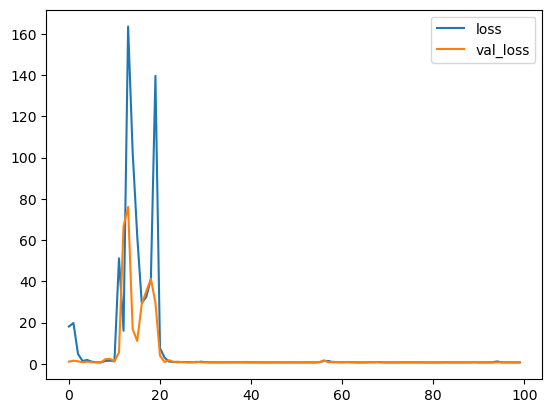

In [11]:
losses = pd.DataFrame(alexnet.history.history)
losses[['loss','val_loss']].plot()
